## Text Embedding Analysis Through Legal-BERT

### Dataset Reading

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../data/metadata.csv")

df.head()

,filename,author,type,text
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \n\n14t..."
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\n\nWONG HOY WOON v. DUNCAN.\n\n1894..."
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\n\nREGINA v. MEE WAH...
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\n\nREGINA r, CORPORATION ..."
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \n\nSupreme Cour...


### Naive Word Embedding Analysis

In [2]:
# Define a function to clean the text
import re

def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    return text.strip()

In [3]:
from nltk.tokenize import word_tokenize

# Create the large corpus by joining all text from all authors
all_text = " ".join(df["text"].tolist())

clean_text = clean_text(all_text)

In [4]:
# Load the tokenizer and model from Hugging Face
from transformers import AutoTokenizer, AutoModel
import torch

# We will use the Legal-BERT model for this task
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
model = AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

# set the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
# Create the word embeddings
# Tokenize the cleaned text into words
tokens = word_tokenize(clean_text)

# Get unique words to avoid redundant computation
unique_tokens = list(set(tokens))

# Print the shape of unique tokens
print(f'There are {len(unique_tokens)} unique tokens in this corpus.')

There are 4905 unique tokens in this corpus.


In [6]:
# Prepare a dictionary to store word embeddings
word_embeddings = {}

# Batch processing for efficiency
batch_size = 32
batches = [unique_tokens[i:i + batch_size] for i in range(0, len(unique_tokens), batch_size)]

for batch in batches:
    # Tokenize the batch
    batch_inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=10)
    with torch.no_grad():
        batch_outputs = model(**batch_inputs)
        # Use the [CLS] token embedding as the word embedding
        for i, word in enumerate(batch):
            word_embedding = batch_outputs.last_hidden_state[i, 0, :].numpy()
            word_embeddings[word] = word_embedding

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [7]:
# Print embedding for the word of interest 'chinese'

print(f"BERT embedding for 'chinese':\n{word_embeddings.get('chinese')}")

BERT embedding for 'chinese':
[-6.20929956e-01 -1.41669914e-01  6.38973951e-01  5.66694997e-02
  2.49504417e-01  3.55757445e-01 -9.64457169e-02  3.54798347e-01
 -2.72701204e-01 -6.37608767e-01  1.72130004e-01  5.87600231e-01
  5.80052547e-02 -1.98573306e-01 -6.22220993e-01  6.23441458e-01
 -2.84138501e-01 -2.01131850e-01 -1.16010487e-01  3.39486867e-01
 -1.49681792e-01  4.16030079e-01  4.64206189e-01 -4.62918758e-01
  3.87408853e-01  6.31607652e-01  6.86673462e-01  2.19447494e-01
 -3.76842201e-01  1.29364863e-01 -2.28453383e-01 -2.85087019e-01
  3.50299895e-01  4.33139503e-01 -4.69817609e-01  2.95414388e-01
  5.21553159e-02 -2.85932124e-02  4.41666007e-01  2.89368480e-01
  3.54161978e-01 -7.48490632e-01  7.74222836e-02 -1.15736835e-01
 -1.74301475e-01  1.22696489e-01 -2.15352607e+00 -3.29317093e-01
  1.01303458e-02 -3.54923382e-02 -1.23484582e-01  6.59714282e-01
 -8.31694156e-03  6.29764497e-01  6.69251561e-01 -4.71155584e-01
  7.91467354e-02 -6.24099374e-01 -4.18075711e-01 -6.55549914

In [8]:
# Compute cosine similarity between all words with Chinese in the model
from scipy.spatial.distance import cosine

similarity_scores = {}

for other_word in word_embeddings.keys():
    if other_word != "chinese":
        similarity = 1 - cosine(word_embeddings["chinese"], word_embeddings[other_word])
        similarity_scores[other_word] = similarity

# Sort by cosine similarity
sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
print("Top 10 most similar words to 'chinese':")
for word, score in sorted_similarity[:10]:
    print(f"{word}: {score:.4f}")

Top 10 most similar words to 'chinese':
japanese: 0.8790
chong: 0.8652
alien: 0.8581
fourteen: 0.8564
jaw: 0.8557
king: 0.8519
hong: 0.8516
contradiction: 0.8485
cousin: 0.8480
inferior: 0.8472


In [9]:
# Compute cosine similarity between all words with Chinaman in the model

similarity_scores = {}

for other_word in word_embeddings.keys():
    if other_word != "chinaman":
        similarity = 1 - cosine(word_embeddings["chinaman"], word_embeddings[other_word])
        similarity_scores[other_word] = similarity

# Sort by cosine similarity
sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
print("Top 10 most similar words to 'chinaman'")
for word, score in sorted_similarity[:10]:
    print(f"{word}: {score:.4f}")

Top 10 most similar words to 'chinaman'
provei: 0.9922
clamor: 0.9916
totally: 0.9916
today: 0.9914
chinamen: 0.9911
interred: 0.9910
unequalled: 0.9909
surely: 0.9906
semitropical: 0.9904
quickly: 0.9904


In [10]:
# Generate a t-SNE plot for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)

embeddings = np.array(list(word_embeddings.values()))
tsne_results = tsne.fit_transform(embeddings)

In [11]:
# Create a DataFrame for visualization
import plotly.express as px

df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['word'] = list(word_embeddings.keys())
# Highlight the word 'chinese' in the plot
keywords = ["chinese", "china", "chinaman", "chinamen"]
df_tsne['highlight'] = df_tsne['word'].apply(lambda x: x if x in keywords else '')

fig = px.scatter(
    df_tsne,
    x='x',
    y='y',
    title='t-SNE Visualization of legal-BERT Word Embeddings',
    color='highlight',                        
    hover_data=['word'], 
    text= 'highlight',
    height=600,
    width=800
)

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


### Text Embedding and Analysis of Crease and Begbie Corpus

In [12]:
# Compile the Crease texts into a single text list
crease_texts = df[df['author'] == 'Crease']['text'].tolist()

# Compile the Begbie texts into a single text list
begbie_texts = df[df['author'] == 'Begbie']['text'].tolist()

# Combine both lists in a dictionary
judge_dict = {
    'Crease': crease_texts,
    'Begbie': begbie_texts
}

In [13]:
# Define a function to embed text using the model
from typing import Union, List

def embed_text(
    text: str,
    focus_token: Union[str, List[str]] = None,
    window: int = 5,
    tokenizer=tokenizer,
    model=model)-> np.ndarray:
    """
    text: the raw string
    focus_token: either a single word, or a list of words to look for
    window: how many tokens on each side to include
    tokenizer: HuggingFace tokenizer
    model: BERT model
    """
    # Run the model once
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state.squeeze(0) 

    if focus_token is None:
        return hidden[0].cpu().numpy()
    
    # Normalize to list
    keywords = (
        [focus_token] if isinstance(focus_token, str)
        else focus_token
    )

    # Pre-tokenize each keyword to its subtoken ids
    kw_token_ids = {
        kw: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(kw))
        for kw in keywords
    }

    input_ids = inputs["input_ids"].squeeze(0).tolist()
    spans = []  # list of (start, end) index pairs

    # find every match of every keyword
    for kw, sub_ids in kw_token_ids.items():
        L = len(sub_ids)
        for i in range(len(input_ids) - L + 1):
            if input_ids[i:i+L] == sub_ids:
                spans.append((i, i+L))

    if not spans:
        # fallback on CLS vector
        return hidden[0].cpu().numpy()

    # For each span, grab the window around it
    vecs = []
    for (start, end) in spans:
        lo = max(1, start - window)
        hi = min(hidden.size(0), end + window)
        # mean‑pool over all tokens in this extended window
        span_vec = hidden[lo:hi].mean(dim=0).cpu().numpy()
        vecs.append(span_vec)

    # Average across all spans
    return np.mean(np.stack(vecs, axis=0), axis=0)

In [14]:
from nltk import sent_tokenize 
# Create a dictionary to hold the mentionings of "Chinese" by author
judge_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen", "immigrant", "immigrants", "immigration"]
for auth, texts in judge_dict.items():
    snippets = []
    for txt in texts:
        sentence = sent_tokenize(txt)
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    judge_snippets[auth] = snippets

In [15]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in judge_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")
    

Snippet size by author:
Crease: 146
Begbie: 108


In [16]:
# Define an ethnicity anchor, not including "chinese"
ethnicities = [
    "Japanese",   "Korean",    "Vietnamese",
    "Filipino",    "Thai",       "Malay",     "Indian",
    "Pakistani",   "Bangladeshi","Nepalese",  "Tibetan",
    "Arab",        "Persian",    "Turkish",   "Slavic",
    "Germanic",    "Celtic",     "Slavic",    "Romani",
    "Jewish",      "Zulu",       "Xhosa",     "Maori",
    "Sami",        "Berber",     "Tamil",     "Punjabi",
    "Bengali",     "Kazakh",     "Uyghur"
]

# Create embeddings
eth_vecs = []
for e in ethnicities:
    eth_vecs.append(embed_text(e))
    
eth_anchor = np.mean(eth_vecs, axis=0)

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



In [17]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': []}

for auth, snippets in judge_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v)


In [18]:
# Create embeddings that subtract the ethnicity anchor
subtracted_embeddings_dict = {'Crease': [], 'Begbie': []}

for auth, embeddings in embeddings_dict.items():
    for emb in embeddings:
        v = emb - eth_anchor
        subtracted_embeddings_dict[auth].append(v)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute per author mean and cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)  
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0] 

print(f"Cosine similarity between Crease and Begbie: {sim_crease_begbie:.4f}")

Cosine similarity between Crease and Begbie: 0.9948


In [20]:
# Compute per author mean and cosine similarity
subtracted_mean_crease = np.mean(subtracted_embeddings_dict["Crease"], axis=0, keepdims=True)  
subtracted_mean_begbie = np.mean(subtracted_embeddings_dict["Begbie"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_begbie)[0, 0] 

print(f"Cosine similarity between Crease and Begbie with ethical axis removed: {sim_crease_begbie_sub:.4f}")

Cosine similarity between Crease and Begbie with ethical axis removed: 0.9971


In [21]:
# We check if the cosine similarity is lower when one subtracted the ethnicity anchor but not the other
sim_crease_sub_begbie = cosine_similarity(mean_crease, subtracted_mean_begbie)[0, 0]
sim_sub_crease_begbie = cosine_similarity(subtracted_mean_crease, mean_begbie)[0, 0]

print(f"Cosine similarity between Crease and Begbie with Begbie removed ethnical axis: {sim_crease_sub_begbie:.4f}")
print(f"Cosine similarity between Crease and Begbie with Crease removed ethnical axis: {sim_sub_crease_begbie:.4f}")

Cosine similarity between Crease and Begbie with Begbie removed ethnical axis: 0.6105
Cosine similarity between Crease and Begbie with Crease removed ethnical axis: 0.6063


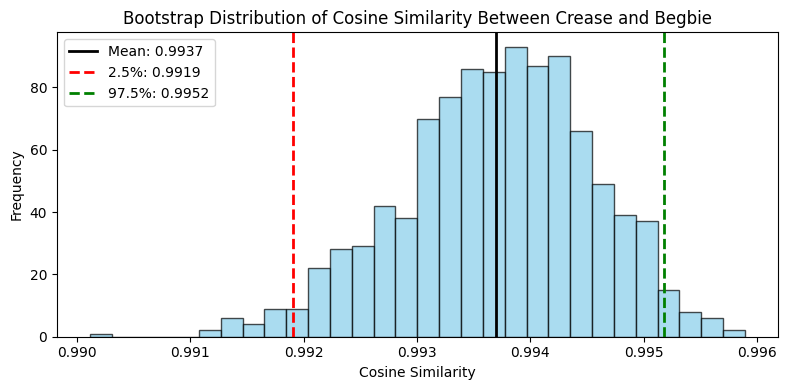

Bootstrap mean cosine similarity between Crease and Begbie: 0.9937
95% Confidence Interval: [0.9919, 0.9952]


In [22]:
import matplotlib.pyplot as plt
# We can bootstrap the similarity score to get a confidence interval
crease_embeddings = np.array(embeddings_dict["Crease"])
begbie_embeddings = np.array(embeddings_dict["Begbie"])

# Convert to arrays
crease_embeddings = np.vstack(crease_embeddings)
begbie_embeddings = np.vstack(begbie_embeddings)

n_boot = 1000 
cosine_scores = []

for _ in range(n_boot):
    # Sample with replacement
    crease_sample = crease_embeddings[np.random.choice(len(crease_embeddings), size=len(crease_embeddings), replace=True)]
    begbie_sample = begbie_embeddings[np.random.choice(len(begbie_embeddings), size=len(begbie_embeddings), replace=True)]
    
    # Compute mean embeddings
    mean_crease_boot = np.mean(crease_sample, axis=0, keepdims=True)
    mean_begbie_boot = np.mean(begbie_sample, axis=0, keepdims=True)
    
    # Compute cosine similarity
    cos_sim = cosine_similarity(mean_crease_boot, mean_begbie_boot)[0][0]
    cosine_scores.append(cos_sim)

# Convert to numpy array
cosine_scores = np.array(cosine_scores)

# Compute 95% confidence interval
lower = np.percentile(cosine_scores, 2.5)
upper = np.percentile(cosine_scores, 97.5)
mean_sim = np.mean(cosine_scores)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 4))
plt.hist(cosine_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for mean and confidence interval
plt.axvline(mean_sim, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_sim:.4f}')
plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5%: {lower:.4f}')
plt.axvline(upper, color='green', linestyle='--', linewidth=2, label=f'97.5%: {upper:.4f}')

plt.title('Bootstrap Distribution of Cosine Similarity Between Crease and Begbie')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print the results
print(f"Bootstrap mean cosine similarity between Crease and Begbie: {mean_sim:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

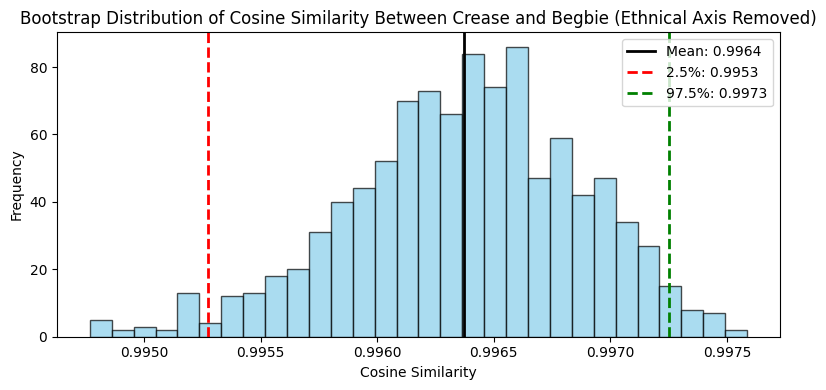

Bootstrap mean cosine similarity between Crease and Begbie with ethnical axis removed: 0.9964
95% Confidence Interval: [0.9953, 0.9973]


In [23]:
# Similarly, bootstrap the similarity score to get a confidence interval
crease_embeddings = np.array(subtracted_embeddings_dict["Crease"])
begbie_embeddings = np.array(subtracted_embeddings_dict["Begbie"])

# Convert to arrays
crease_embeddings = np.vstack(crease_embeddings)
begbie_embeddings = np.vstack(begbie_embeddings)

n_boot = 1000 
subtracted_cosine_scores = []

for _ in range(n_boot):
    # Sample with replacement
    crease_sample = crease_embeddings[np.random.choice(len(crease_embeddings), size=len(crease_embeddings), replace=True)]
    begbie_sample = begbie_embeddings[np.random.choice(len(begbie_embeddings), size=len(begbie_embeddings), replace=True)]
    
    # Compute mean embeddings
    mean_crease_boot = np.mean(crease_sample, axis=0, keepdims=True)
    mean_begbie_boot = np.mean(begbie_sample, axis=0, keepdims=True)
    
    # Compute cosine similarity
    cos_sim = cosine_similarity(mean_crease_boot, mean_begbie_boot)[0][0]
    subtracted_cosine_scores.append(cos_sim)

# Convert to numpy array
subtracted_cosine_scores = np.array(subtracted_cosine_scores)

# Compute 95% confidence interval
lower = np.percentile(subtracted_cosine_scores, 2.5)
upper = np.percentile(subtracted_cosine_scores, 97.5)
mean_sim = np.mean(subtracted_cosine_scores)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 4))
plt.hist(subtracted_cosine_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for mean and confidence interval
plt.axvline(mean_sim, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_sim:.4f}')
plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5%: {lower:.4f}')
plt.axvline(upper, color='green', linestyle='--', linewidth=2, label=f'97.5%: {upper:.4f}')

plt.title('Bootstrap Distribution of Cosine Similarity Between Crease and Begbie (Ethnical Axis Removed)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print the results
print(f"Bootstrap mean cosine similarity between Crease and Begbie with ethnical axis removed: {mean_sim:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

In [24]:
# Testing if the ethnical axis removal has a significant effect on the similarity score
# We can use a bootstrapped t-test to compare the means of the two distributions
from scipy.stats import ttest_ind

# Perform bootstrapped t-test
t_stat, p_value = ttest_ind(subtracted_cosine_scores, cosine_scores, equal_var=False)

# Print the results
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in mean cosine similarity is statistically significant.")
else:
    print("The difference in mean cosine similarity is not statistically significant.")

t-statistic: 86.1236
p-value: 0.0000
The difference in mean cosine similarity is statistically significant.


With the above test on embeddings with or without the ethnical axis, we confirmed that the difference between cosine similarities of Crease and Begbie are statistically significantly biased by the ethnical factors. However, with the small difference in real cosine similarity, we can conclude that the two characters are still very similar in terms of their text embeddings, thus the bias is not very significant in the real world. 

In [25]:
# Create UMAP projection for visualization
import umap 

all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
proj = reducer.fit_transform(all_vecs) 

In [26]:
# plot using plotly to further explore
import plotly.express as px
import textwrap

def wrap_text(text, width=60):
    return '<br>'.join(textwrap.wrap(text, width=width))

umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in judge_snippets for snip in judge_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=50))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [27]:
# Print out the 10 most similar embedding sentences to Crease's mean embedding
from sklearn.metrics.pairwise import cosine_similarity

crease_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in judge_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_crease)[0][0]
        crease_similarity_df.loc[len(crease_similarity_df)] = [
            auth, snippet, similarity
        ]

# Sort by similarity score
crease_sorted_similarity = crease_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Crease's mean embedding:\n")

for _, row in crease_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Crease's mean embedding:

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.9635

Author: Crease
Sentence: In coming to British Columbia, and while here, the Chinese have no idea of interfering with the
property of the white population in any way beyond the ordinary competition which they offer in the
labor market.
Similarity Score: 0.9630

Author: Crease
Sentence: The strike of the Chinese in Victoria when resisting an intentionally discriminating and illegal tax
of $30 a head on all Chinese-although it occurred a few years ago-is too fresh in the recollection
to be forgotten.
Simil

In [28]:
# Print out the 10 most similar embedding sentences to Begbie's mean embedding
begbie_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in judge_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_begbie)[0][0]
        begbie_similarity_df.loc[len(begbie_similarity_df)] = [
            auth, snippet, similarity
        ]

# Sort by similarity score
begbie_sorted_similarity = begbie_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Begbie's mean embedding:\n")

for _, row in begbie_sorted_similarity.head(10).iterrows():
    
    wrapped_para = textwrap.fill(row['Text'], width=100)
    
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Begbie's mean embedding:

Author: Crease
Sentence: Though possessed of all the qualities I have described, Chinamen do not make good settlers in the
sense of raising up citizens of a free.
Similarity Score: 0.9644

Author: Begbie
Sentence: Whites who have evil communications with Chinese must themselves be lamentably depraved beforehand;
and so, I should be disposed to say, immoral Chinese are not only not more injurious, but they are
quite innocuous to the morals of the whites, in comparison with white people of similar or allied
habits.
Similarity Score: 0.9620

Author: Crease
Sentence: The strike of the Chinese in Victoria when resisting an intentionally discriminating and illegal tax
of $30 a head on all Chinese-although it occurred a few years ago-is too fresh in the recollection
to be forgotten.
Similarity Score: 0.9610

Author: Crease
Sentence: I do not say that all these evils whether white or Chinese should not be determinedly suppressed,
but t

The mixture occurrence of the two judges in the most similar sentences to the mean embeddings of the two also shows that the stance are very similar in terms of their text embeddings. 

### The Comparison of Crease's and Begbie's Rulings and the Chinese Regulation Act of 1884

In [29]:
crease_cases = df[(df['author'] == 'Crease') & (df['type'] == 'case')]['text'].tolist()
begbie_cases = df[(df['author'] == 'Begbie') & (df['type'] == 'case')]['text'].tolist()
act_1884 = df[df['type'] == 'act']['text'].tolist()

act_dict = {
    'Crease': crease_cases,
    'Begbie': begbie_cases,
    'Act 1884': act_1884}

In [30]:
act_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen"]
for auth, texts in act_dict.items():
    snippets = []
    for txt in texts:
        sentence = sent_tokenize(txt)
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    act_snippets[auth] = snippets

In [31]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in act_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")

Snippet size by author:
Crease: 86
Begbie: 18
Act 1884: 24


In [32]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, snippets in act_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v)

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



In [33]:
# Create embeddings that subtract the ethnicity anchor
subtracted_embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, embeddings in embeddings_dict.items():
    for emb in embeddings:
        v = emb - eth_anchor
        subtracted_embeddings_dict[auth].append(v)

In [34]:
# Compute the pairwise cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)
mean_act_1884 = np.mean(embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0]
sim_crease_act_1884 = cosine_similarity(mean_crease, mean_act_1884)[0, 0]
sim_begbie_act_1884 = cosine_similarity(mean_begbie, mean_act_1884)[0, 0]

print(f"Cosine similarity between Crease and Begbie: {sim_crease_begbie:.4f}")
print(f"Cosine similarity between Crease and Act 1884: {sim_crease_act_1884:.4f}")
print(f"Cosine similarity between Begbie and Act 1884: {sim_begbie_act_1884:.4f}")

Cosine similarity between Crease and Begbie: 0.9893
Cosine similarity between Crease and Act 1884: 0.9757
Cosine similarity between Begbie and Act 1884: 0.9600


In [35]:
# Compute the pairwise cosine similarity with subtracted embeddings
subtracted_mean_crease = np.mean(subtracted_embeddings_dict["Crease"], axis=0, keepdims=True)
subtracted_mean_begbie = np.mean(subtracted_embeddings_dict["Begbie"], axis=0, keepdims=True)
subtracted_mean_act_1884 = np.mean(subtracted_embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_begbie)[0, 0]
sim_crease_act_1884_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_act_1884)[0, 0]
sim_begbie_act_1884_sub = cosine_similarity(subtracted_mean_begbie, subtracted_mean_act_1884)[0, 0]

print(f"Cosine similarity between Crease and Begbie with ethnical axis removed: {sim_crease_begbie_sub:.4f}")
print(f"Cosine similarity between Crease and Act 1884 with ethnical axis removed: {sim_crease_act_1884_sub:.4f}")
print(f"Cosine similarity between Begbie and Act 1884 with ethnical axis removed: {sim_begbie_act_1884_sub:.4f}")

Cosine similarity between Crease and Begbie with ethnical axis removed: 0.9940
Cosine similarity between Crease and Act 1884 with ethnical axis removed: 0.9865
Cosine similarity between Begbie and Act 1884 with ethnical axis removed: 0.9776


In [36]:
# Create UMAP projection for visualization
import umap 

all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"] + embeddings_dict["Act 1884"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"])) + (['Act 1884'] * len(embeddings_dict["Act 1884"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
proj = reducer.fit_transform(all_vecs) 

In [37]:
umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in act_snippets for snip in act_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=50))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Zero-shot Stance Classification with legal-BERT

In [38]:
# Create pipeline for zero-shot classification
from transformers import pipeline

zero_shot = pipeline("zero-shot-classification", model= 'facebook/bart-large-mnli', tokenizer='facebook/bart-large-mnli')

labels = [
  "positive stance toward the equal rights of Chinese immigrants",
  "neutral stance toward the equal rights of Chinese immigrants",
  "negative stance toward the equal rights of Chinese immigrants"
]

def get_scores(snippet):
    out = zero_shot(snippet, candidate_labels=labels)
    return dict(zip(labels, out["scores"]))

Device set to use cpu


In [39]:
# Run zero-shot classification on the snippets from the Chinese Regulation Act 1884
act_scores = {}

for auth, snippets in act_snippets.items():
    scores = []
    for snip in snippets:
        score = get_scores(snip)
        scores.append(score)
    act_scores[auth] = scores

rows = []

for auth, snippets in act_snippets.items():
    for snip, score_dict in zip(snippets, act_scores[auth]):
        row = {
            "Author": auth,
            "Text": snip,
            "Pro": score_dict["positive stance toward the equal rights of Chinese immigrants"],
            "Neutral": score_dict["neutral stance toward the equal rights of Chinese immigrants"],
            "Cons": score_dict["negative stance toward the equal rights of Chinese immigrants"]
        }
        rows.append(row)

# Create long-form DataFrame
df_scores = pd.DataFrame(rows)

# Group by author and calculate mean scores
mean_scores = df_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].mean()

print("Mean scores by author:")
print(mean_scores)


Mean scores by author:
               Pro   Neutral      Cons
Author                                
Act 1884  0.620911  0.236782  0.142306
Begbie    0.768878  0.152377  0.078746
Crease    0.737597  0.170099  0.092304


In [40]:
df_scores['Text'] = df_scores['Text'].apply(lambda t: wrap_text(t, width = 50))

fig = px.scatter(
    df_scores,
    x="Pro",
    y="Cons",
    color="Author",
    hover_data=["Text"],
    title="Pros vs Cons Scores by Author",
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [41]:
# Plot histogram for Pro scores
fig_pro = px.histogram(
    df_scores,
    x="Pro",
    color="Author",
    title="Distribution of Pro Scores by Author",
    nbins=30,
    opacity=0.7,
    labels={"Pro": "Pro Score"}
)
fig_pro.update_layout(
    xaxis_title="Pro Score",
    yaxis_title="Frequency",
    width=800,
    height=500
)
fig_pro.show()

# Plot histogram for Cons scores
fig_cons = px.histogram(
    df_scores,
    x="Cons",
    color="Author",
    title="Distribution of Cons Scores by Author",
    nbins=30,
    opacity=0.7,
    labels={"Cons": "Cons Score"}
)
fig_cons.update_layout(
    xaxis_title="Cons Score",
    yaxis_title="Frequency",
    width=800,
    height=500
)
fig_cons.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Domain‐Adaptive Pretraining